In [28]:
import numpy as np
import os
from osgeo import gdal
import matplotlib.pyplot as plt
import tifffile
from collections import defaultdict
import csv

In [29]:
def img_transposition(img):

    bands=[0, 1, 2, 7, 8, 9]
    # img1=np.transpose(img[0,bands,:,:],(1,2,0))
    # img2=np.transpose(img[1,bands,:,:],(1,2,0))
    # img3=np.transpose(img[2,bands,:,:],(1,2,0))
    img_shape=img.shape
    params=np.zeros(6)
    new_img_time_series = np.empty((0, img_shape[1], img_shape[2], img_shape[3]), dtype=img.dtype)
    for i in range(img_shape[1]):

        params[0]=np.mean(img[i,0,:,:])
        params[1]=np.mean(img[i,1,:,:])
        params[2]=np.mean(img[i,2,:,:])
        params[3]=np.median(img[i,0,:,:])
        params[4]=np.median(img[i,1,:,:])
        params[5]=np.median(img[i,2,:,:])
        
        if np.all(params[0:3] < 4000) and np.all(params[3:6] > 200):
            new_img_time_series = np.vstack((new_img_time_series, img[i,:,:,:][np.newaxis]))



    new_img_time_series = np.array(new_img_time_series)
    new_shape=new_img_time_series.shape

    # print(new_shape)
    middle_index = new_shape[0] // 2
    img1 = np.transpose(new_img_time_series[0, bands, :, :], (1, 2, 0))
    img2 = np.transpose(new_img_time_series[middle_index, bands, :, :], (1, 2, 0))
    img3 = np.transpose(new_img_time_series[-1, bands, :, :], (1, 2, 0))


    # merged_img=np.concatenate([img1,img2,img3], axis=2)
    merged_img =np.dstack((img1,img2,img3))
    # transposed_img = np.transpose(merged_img, (2,0,1))
    # print(transposed_img.shape)
    return merged_img

In [30]:
raster_img_path=r"F:\mgr_datasets\PASTIS\DATA_S2\S2_20023.npy"
mask_path=r"F:\mgr_datasets\PASTIS\ANNOTATIONS\TARGET_20023.npy"
csv_path=r"F:\mgr_datasets\spectral_results\spectral_results_1.csv"
num_class=19
image_name="test image"

In [31]:
dataset = np.load(raster_img_path, allow_pickle=True)
mask=np.load(mask_path)

In [32]:
raster_img=img_transposition(dataset)

In [33]:
channels_mask, width_mask, height_mask =mask.shape

In [34]:
num_channels=6

class_pixels = defaultdict(lambda: defaultdict(list))

for class_n in range(num_class+1):  # Iterujemy przez wszystkie klasy
    # Jeśli klasa nie występuje w obrazie, dodajemy pusty wektor dla tej klasy
    if class_n not in mask[0,:,:]:
        class_pixels[class_n] = {channel: [] for channel in range(num_channels)}
        continue

    # Dla każdego piksela w obrazie
    for width in range(width_mask):
        for height in range(height_mask):
            if mask[0, width, height] == class_n:
                # Jeśli klasa występuje w obrazie, dodajemy piksel do odpowiedniego kanału
                for channel in range(num_channels):
                    pixel_value = raster_img[width, height, channel]
                    class_pixels[class_n][channel].append(pixel_value)

In [35]:
num_classes = len(class_pixels.keys())
print("Liczba klas w class_pixels:", num_classes)

Liczba klas w class_pixels: 20


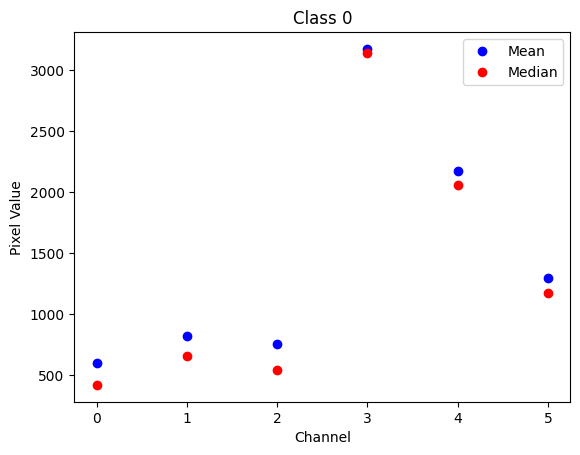

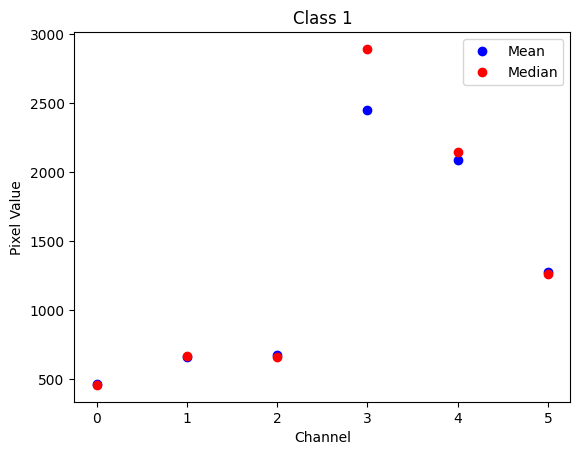

c:\Users\wojtek\.conda\envs\gdal2\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\Users\wojtek\.conda\envs\gdal2\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


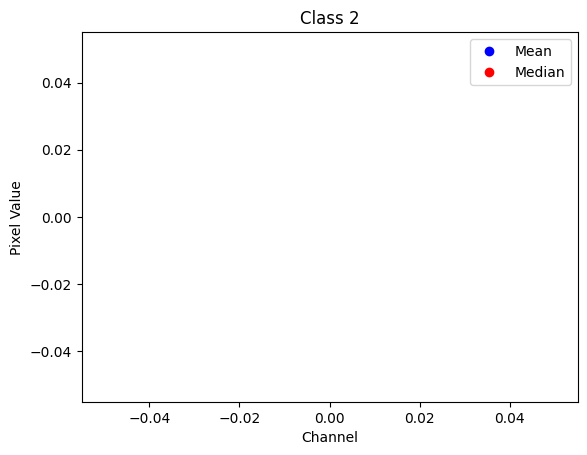

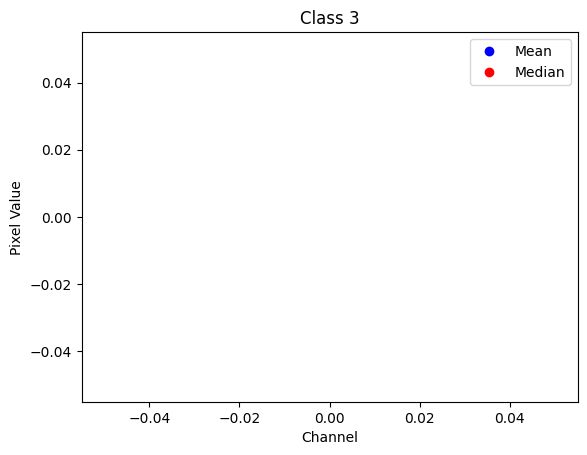

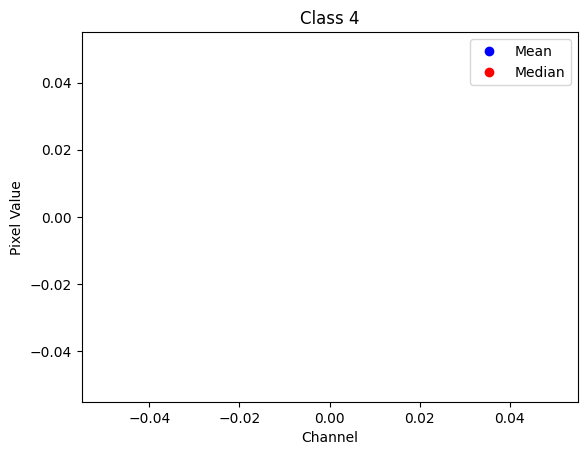

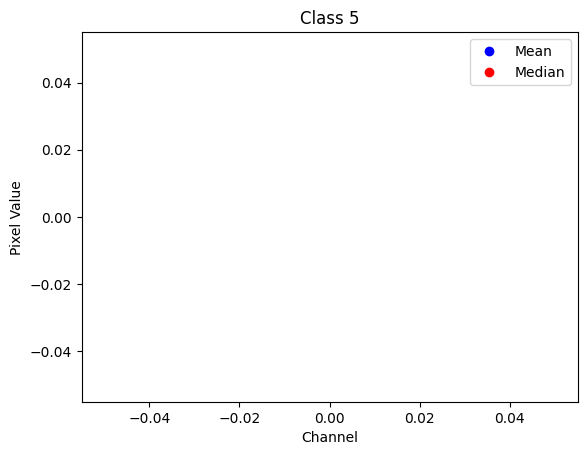

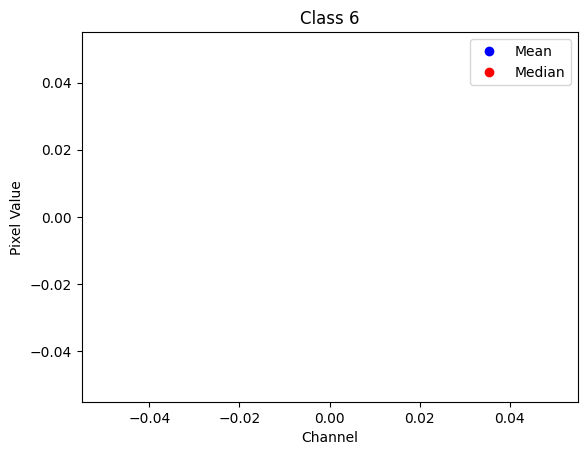

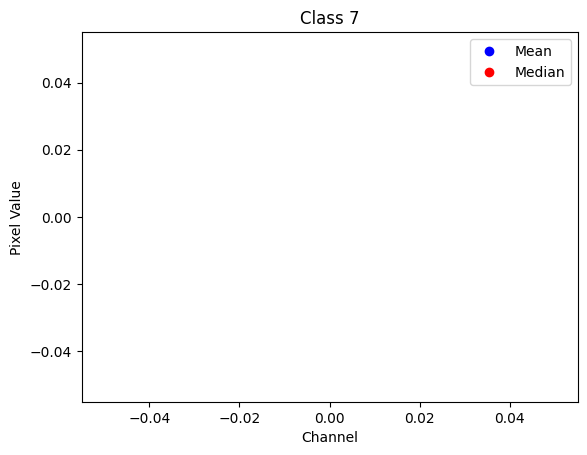

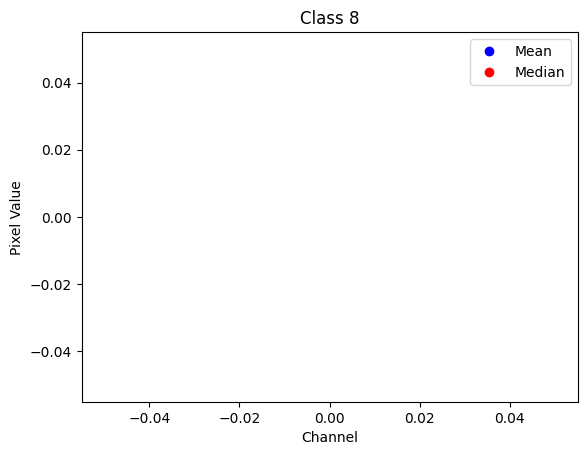

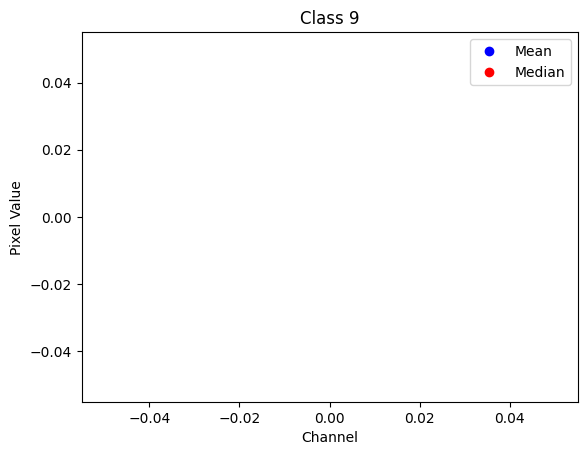

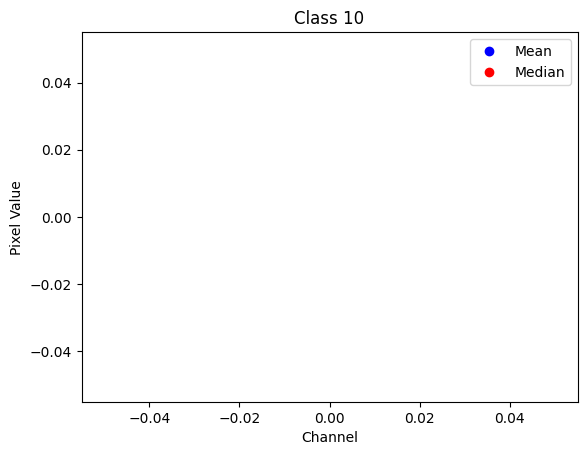

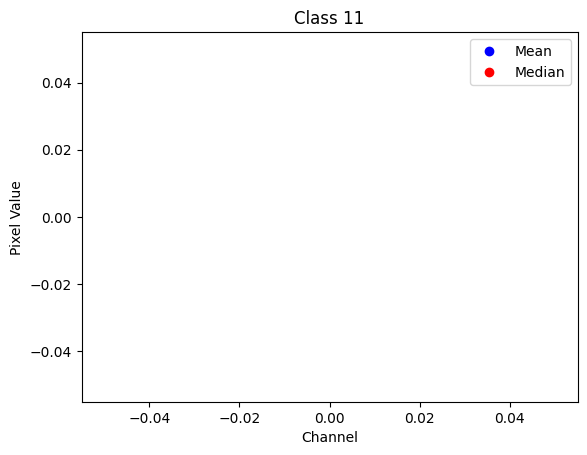

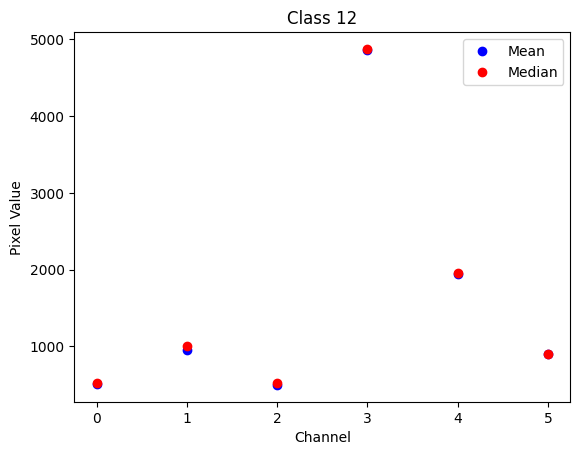

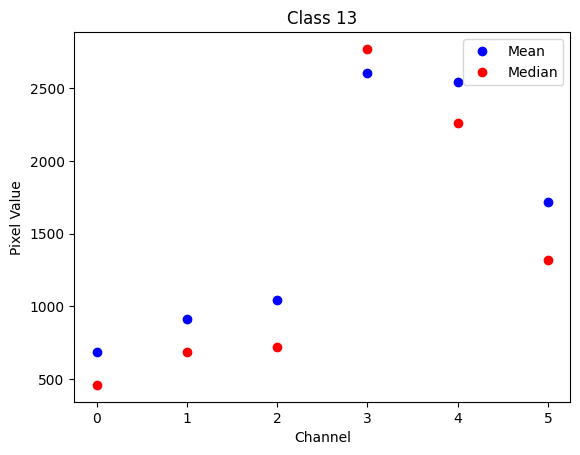

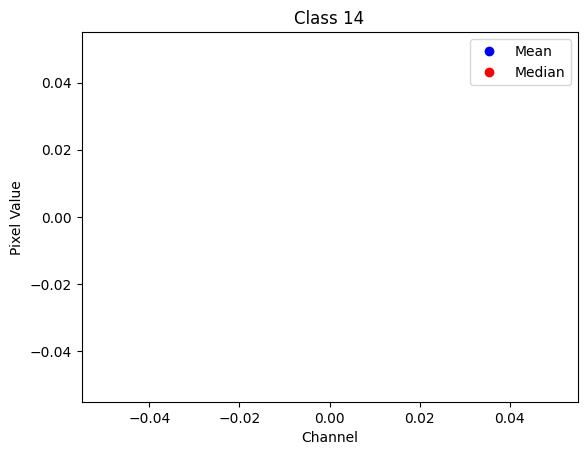

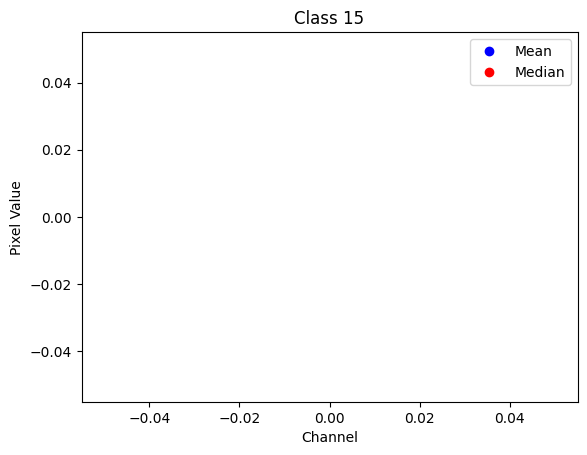

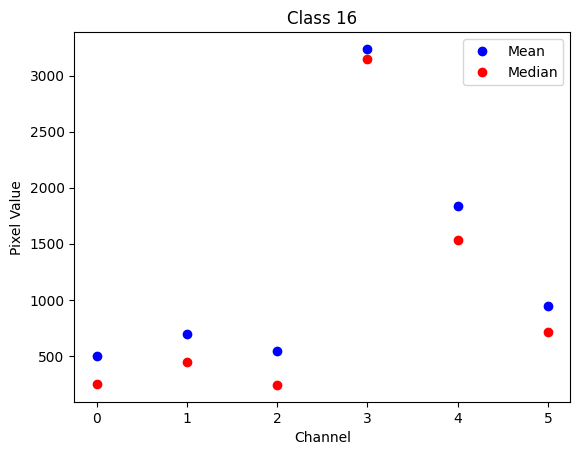

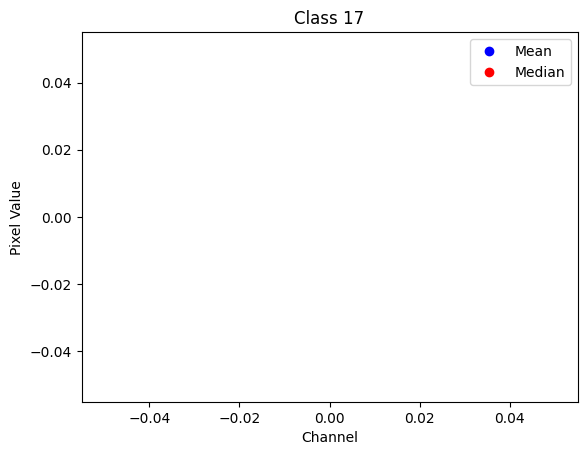

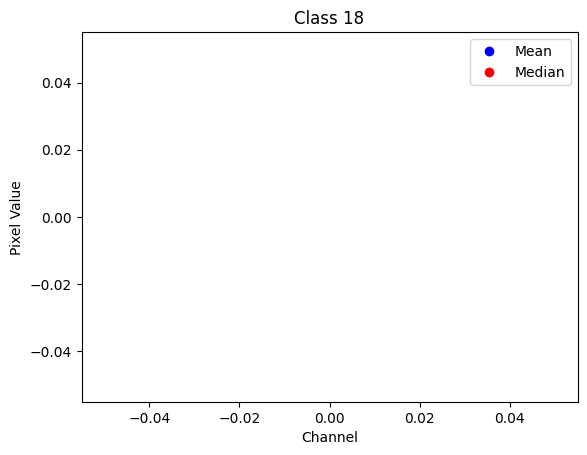

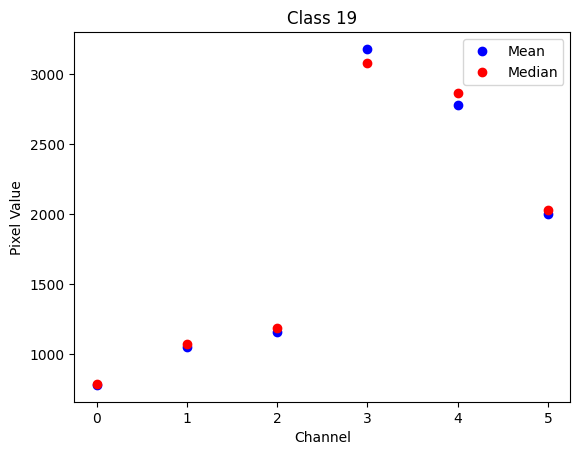

In [36]:

for class_n, channels_data in class_pixels.items():
    # Tworzymy wykres
    plt.figure()
    plt.title(f"Class {class_n}")

    # Dla każdego kanału
    for channel, pixels in channels_data.items():
        # Obliczamy średnią i medianę
        mean_value = np.mean(pixels)
        median_value = np.median(pixels)
        

        # Wykres średniej wartości dla każdego kanału
        plt.plot(channel, mean_value, 'bo')
        # Wykres mediany dla każdego kanału
        plt.plot(channel, median_value, 'ro')

    # Etykiety oznaczające medianę i średnią wartość
    plt.plot([], [], 'bo', label='Mean')
    plt.plot([], [], 'ro', label='Median')

    # Ustawienia osi i legendy
    plt.xlabel('Channel')
    plt.ylabel('Pixel Value')
    plt.legend()

    # Pokaż wykres
    plt.show()


In [38]:
with open(csv_path,mode='w', newline='') as file:
    writer=csv.writer(file)
    headers = ["Image", "Class", "Channel", "Mean", "Median"]
    writer.writerow(headers)
    
    # Iteracja przez każdą klasę w class_pixels
    for class_n, channels_data in class_pixels.items():
        # Iteracja przez każdy kanał w klasie
        for channel, pixels in channels_data.items():
            # Obliczanie średniej i mediany
            mean_value = np.mean(pixels)
            median_value = np.median(pixels)
            
            # Zapisanie danych do pliku CSV
            row = [image_name, class_n, channel, mean_value, median_value]
            writer.writerow(row)